In [3]:
import numpy as np
import os
path = '/hy-tmp/'
data_train = np.load(path+'depth_train.npy')
data_test = np.load(path+'depth_test.npy')
labels_train = np.load(path+'label_train.npy')
labels_test = np.load(path+'label_test.npy')

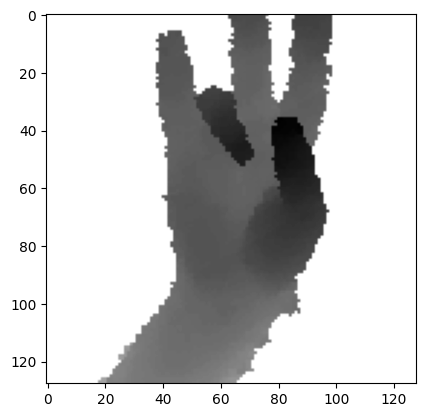

In [4]:
# 展示图片
import matplotlib.pyplot as plt
plt.imshow(data_train[0], cmap='gray')

In [2]:
from PIL import Image
data_train = [Image.fromarray(data_train[i]) for i in range(len(data_train))]
data_test = [Image.fromarray(data_test[i]) for i in range(len(data_test))]

In [3]:
# 使用pytorch——resnet50进行回归训练
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import torchvision.transforms as transforms
tf = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            ])
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.data)
trainset = MyDataset(data_train, labels_train, transform=tf)
testset = MyDataset(data_test, labels_test, transform=tf)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=os.cpu_count())
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=os.cpu_count())
# 使用torchvision中的resnet50
model = torchvision.models.resnet50(pretrained=False,num_classes=42)
# 修改模型输入通道数
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# 使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [4]:
# 训练
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Finished Training')


[1,     1] loss: 0.004
[2,     1] loss: 0.001
[3,     1] loss: 0.001
[4,     1] loss: 0.001
[5,     1] loss: 0.001
[6,     1] loss: 0.001
[7,     1] loss: 0.001
[8,     1] loss: 0.001
[9,     1] loss: 0.001
[10,     1] loss: 0.001
Finished Training


In [7]:
# 回归测试，结果是一个42维的向量，计算指标是R2
import math
model.eval()
with torch.no_grad():
    # 计算训练集的R2
    train_pred = []
    train_true = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        train_pred.extend(outputs.cpu().numpy())
        train_true.extend(labels.cpu().numpy())
    train_pred = np.array(train_pred)
    train_true = np.array(train_true)
    train_r2 = 1 - np.sum((train_pred - train_true)**2) / np.sum((train_true - np.mean(train_true))**2)
    print('train_r2: ', train_r2)
    # 计算测试集的R2
    test_pred = []
    test_true = []
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_pred.extend(outputs.cpu().numpy())
        test_true.extend(labels.cpu().numpy())
    test_pred = np.array(test_pred)
    test_true = np.array(test_true)
    test_r2 = 1 - np.sum((test_pred - test_true)**2) / np.sum((test_true - np.mean(test_true))**2)
    print('test_r2: ', test_r2)
    

train_r2:  0.5009891390800476
test_r2:  0.49129819869995117


In [6]:
positions = []
for f in labels_train:
    positions.append([list(map(float, f))])
labels_train = np.reshape(np.array(positions), (len(labels_train), 14, 3))
positions = []
for f in labels_test:
    positions.append([list(map(float, f))])
labels_test = np.reshape(np.array(positions), (len(labels_test), 14, 3))

In [10]:
def get_param():
    return 588.03, -587.07, 320, 240
params = get_param()
def pixel2world(x, fx, fy, ux, uy):
    x[:, :, 0] = (x[:, :, 0] - ux) * x[:, :, 2] / fx
    x[:, :, 1] = (x[:, :, 1] - uy) * x[:, :, 2] / fy
    return x
def count_error(outputs, labels):
    gt = pixel2world(labels, *params)
    outputs = pixel2world(np.reshape(outputs, (len(outputs), 14, 3)), *params)
    errors = np.sqrt(np.sum((gt - outputs) ** 2, axis=2))
    return np.mean(errors)
model.eval()
outputs = []
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs.extend(model(inputs).cpu().numpy())
print('train mean error: ', count_error(np.array(outputs), labels_train))

outputs = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs.extend(model(inputs).cpu().numpy())
print('test mean error: ', count_error(np.array(outputs), labels_test))




train mean error:  0.46365205192947284
test mean error:  0.40825121906814277


In [6]:
# 保存模型
# torch.save(model.state_dict(), path+'model.pth')
# 加载模型
model.load_state_dict(torch.load(path+'model.pth'))

<All keys matched successfully>

In [ ]:
# 可视化
import matplotlib.pyplot as plt
import numpy as np
import os

from os.path import join
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(1024)

class NYU_HPD(object):
	"""docstring for NYU hand pose dataset"""
	def __init__(self,
				 dataset_dir='./train/',
				 image_index=1,
				 kinect_index=1):
		super(NYU_HPD, self).__init__()

		filename_prefix = '%d_%07d' % (kinect_index, image_index)

		self.kinect_index = kinect_index
		self.image_index = image_index
		self.rgb_path = join(dataset_dir,
									 'rgb_%s.png' % filename_prefix)
		self.depth_path = join(dataset_dir,
									   'depth_%s.png' % filename_prefix)
		self.synthdepth_path = join(dataset_dir,
											'synthdepth_%s.png' % filename_prefix)
		self.joint_path = join(dataset_dir, 'joint_data.mat')

	# loading very large images
	def load_image(self, img_path):
		assert os.path.isfile(img_path), 'missing image: %s' % img_path
		img = plt.imread(img_path)

		if np.max(img) <= 1.5:
			np.clip(img, a_min=0, a_max=1, out=img)
			# this command split should reduce mount of required memory
			np.multiply(img, 255, out=img)
			img = img.astype(np.uint8, copy=False)

		return img

	# Load and display an RGB example
	def show_rgb(self):
		rgb = self.load_image(self.rgb_path)
		fig = plt.figure()
		plt.imshow(rgb)
		plt.axis('off')
		plt.show()

	# Load and display a synthdepth/depth example
	def show_depth(self, synth=False):
		# The top 8 bits of depth are packed into green 
		# and the lower 8 bits into blue
		if synth:
			depth = self.load_image(self.synthdepth_path)
		else:
			depth = self.load_image(self.depth_path)
		depth = depth[:, :, 2].astype('uint16') + \
					 (depth[:, :, 1].astype('uint16') << 8)
		ind = np.nonzero(depth)
		plt.imshow(depth,
				   cmap='gray',
				   vmax=np.max(depth[ind]) + 10,
				   vmin=np.min(depth[ind]) - 10)
		plt.axis('off')
		plt.show()

	# Load the UVD Coefficients and display them on the depth image
	def show_joints(self):
		dat = loadmat(self.joint_path)
		jnt_uvd = dat['joint_uvd'][self.kinect_index - 1, self.image_index - 1, :, :]

		jnt_colors = np.random.rand(jnt_uvd.shape[0], 3)

		fig = plt.figure()
		plt.scatter(jnt_uvd[:, 0], jnt_uvd[:, 1],
					c=jnt_colors,
					alpha=0.75)

		self.show_depth()

	# Visualize the hand and the joints in 3D
	def show_3D_hand(self):
		for idx in range(2):
			if idx:
				depth = self.load_image(self.synthdepth_path)
			else:
				depth = self.load_image(self.depth_path)
			depth = depth[:, :, 2].astype('uint16') + \
					(depth[:, :, 1].astype('uint16') << 8)

			uvd = self.depth2uvd(depth)
			xyz = self.uvd2xyz(uvd)

			points = xyz.reshape([xyz.shape[0] * \
								  xyz.shape[1], 3])
			dat = loadmat(self.joint_path)
			jnt_uvd = dat['joint_uvd'][self.kinect_index - 1, self.image_index - 1, :, :]

			jnt_colors = np.random.rand(jnt_uvd.shape[0], 3)

			hand_points = self.uvd2xyz(np.expand_dims(jnt_uvd,
													  axis=0))
			hand_points = np.squeeze(hand_points)
			# Collect the points within the AABBOX of the hand
			axis_bounds = [min(hand_points[:, 0]), max(hand_points[:, 0]),
						   min(hand_points[:, 1]), max(hand_points[:, 1]),
						   min(hand_points[:, 2]), max(hand_points[:, 2])]
			axis_bounds = np.array(axis_bounds)
			axis_bounds[0:6:2] = axis_bounds[0:6:2] - 20
			axis_bounds[1:6:2] = axis_bounds[1:6:2] + 20

			ipnts = [points[i, 0] >= axis_bounds[0] and
					 points[i, 0] <= axis_bounds[1] and
					 points[i, 1] >= axis_bounds[2] and
					 points[i, 1] <= axis_bounds[3] and
					 points[i, 2] >= axis_bounds[4] and
					 points[i, 2] <= axis_bounds[5]
					 for i in range(points.shape[0])]

			points = points[ipnts, :]

			ax = plt.axes(projection='3d')
			# Visualize the hand point cloud
			ax.plot3D(points[:, 0],
					  points[:, 2],
					  points[:, 1],
					  '.')
			# ax.view_init(elev=0, azim=0)
			ax.set_xlabel('x')
			ax.set_ylabel('y')
			ax.set_zlabel('z')

			ax.scatter(hand_points[:, 0],
					   hand_points[:, 2],
					   hand_points[:, 1],
					   c=jnt_colors)

			plt.show()

	# Visualize the depth in 3D
	def show_3D_body(self):
		depth = self.load_image(self.depth_path)
		depth = depth[:, :, 2].astype('uint16') + \
				(depth[:, :, 1].astype('uint16') << 8)

		uvd = self.depth2uvd(depth)
		xyz = self.uvd2xyz(uvd)
		# uvd_ = self.xyz2uvd(xyz)

		# Decimate the image (otherwise rendering will be too slow)
		decimation = 4
		xyz_decimated = xyz[0:xyz.shape[0]:decimation,
						0:xyz.shape[1]:decimation, :]
		points = xyz_decimated.reshape([xyz_decimated.shape[0] * \
										xyz_decimated.shape[1], 3])

		# Collect the points within the AABBOX of the non-background points
		body_points = points[points[:, 2] < 2000, :]
		axis_bounds = [min(body_points[:, 0]), max(body_points[:, 0]),
					   min(body_points[:, 1]), max(body_points[:, 1]),
					   min(body_points[:, 2]), max(body_points[:, 2])]

		fig = plt.figure()
		ax = plt.axes(projection='3d')
		# Visualize the entire point cloud
		ax.plot3D(body_points[:, 0],
				  body_points[:, 2],
				  body_points[:, 1],
				  'b.')
		# ax.view_init(elev=0, azim=0)
		ax.set_xlabel('x')
		ax.set_ylabel('y')
		ax.set_zlabel('z')

		plt.xlim(axis_bounds[0:2])
		plt.ylim(axis_bounds[4:6])
		# plt.zlim(axis_bounds[4:6])

		plt.show()

	def depth2uvd(self, depth):
		v, u = np.mgrid[0:depth.shape[0], 0:depth.shape[1]]
		uvd = np.dstack((u, v, depth))

		return uvd

	def uvd2xyz(self, uvd):
		xRes = 640
		yRes = 480
		xzFactor = 1.08836710
		yzFactor = 0.817612648

		normalizedX = uvd[:,:, 0].astype('float') / xRes - 0.5
		normalizedY = 0.5 - uvd[:,:, 1].astype('float') / yRes

		xyz = np.zeros_like(uvd, dtype='float')
		xyz[:, :, 2] = uvd[:,:, 2].astype('float')
		xyz[:, :, 1] = normalizedY * xyz[:, :, 2] * yzFactor
		xyz[:, :, 0] = normalizedX * xyz[:, :, 2] * xzFactor

		return xyz

	def xyz2uvd(self, xyz):
		halfResX = 640 / 2
		halfResY = 480 / 2
		coeffX = 588.036865
		coeffY = 587.075073

		uvd = np.zeros_like(xyz)
		uvd[:, :, 0] = coeffX * xyz[:, :, 0] / xyz[:,:,2] + halfResX
		uvd[:, :, 1] = halfResY - coeffY * xyz[:,:, 1] / xyz[:, :, 2]
		uvd[:, :, 2] = xyz[:, :, 2]

		return uvd


def main():
	dataset_dir = './train/'
	image_index = 1
	kinect_index = 1

	nyu = NYU_HPD(dataset_dir, image_index, kinect_index)
	nyu.show_rgb()
	nyu.show_3D_hand()
	nyu.show_joints()


if __name__ == '__main__':
	main()
